In [ ]:
install.packages(c("dplyr", "glmnet", "zoo", "lubridate"))


In [ ]:
library(dplyr)
library(glmnet)
library(zoo)
library(lubridate)

In [7]:
clean_oil_data = function(filename) {
  read.csv2(filename) %>% 
    filter(!is.na(Date)) %>% 
    # put Date into dateformat
    mutate(Date = as.Date(Date, "%d.%m.%Y")) %>% 
    # put all other variables into numer format
    mutate(across(-Date, ~ as.numeric(as.character(.))))
}

files = list(
  "Industry_D.csv", 
  "Industry_M.csv", 
  "Industry_W.csv", 
  "Macro_M.csv", 
  "StockPrices_M.csv"
)

cleaned_data = lapply(files, clean_oil_data)

industry_d = cleaned_data[[1]]
industry_m = cleaned_data[[2]] %>% 
# these variables already appear inside industry_d
  select(-any_of(c("CL1", "CL2", "Brent", "CRKS321C.Index", "Baltic.Dry.Index", "datadate")))
industry_w = cleaned_data[[3]]
macro_m = cleaned_data[[4]]
stockprices_m = cleaned_data[[5]]

head(industry_d)
head(industry_m)

,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-07-30,74.73,73.88,78.63,21.883,1762
2,2024-07-29,75.81,74.80,79.78,22.171,1797
3,2024-07-26,77.16,76.00,81.13,21.071,1808
4,2024-07-25,78.28,77.11,82.37,20.832,1834
5,2024-07-24,77.59,76.58,81.71,19.776,1864
6,2024-07-23,76.96,75.92,81.01,21.118,1869


,Date,Daily.Production,Inventories,Rig.Count,Commercial.Long,Commercial.Short,Total.Open.Interest,X,X.1,X.2,X.3
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2024-06-28,13200,821134,581,1600085,1631509,3231594,NA,NA,NA,NA
2,2024-05-31,13100,826109,600,1750160,1785108,3535268,NA,NA,NA,NA
3,2024-04-30,13100,827161,613,1708427,1751709,3460136,NA,NA,NA,NA
4,2024-03-29,13100,815058,621,1687838,1725350,3413188,NA,NA,NA,NA
5,2024-02-29,13300,807417,626,1583286,1606750,3190036,NA,NA,NA,NA
6,2024-01-31,13000,779314,621,1673204,1695615,3368819,NA,NA,NA,NA


In [8]:
# set a grid for the date range
date_grid = data.frame(
  Date = seq(
    from = min(
      industry_d$Date,
      industry_w$Date,
      industry_m$Date,
      macro_m$Date,
      stockprices_m$Date,
      na.rm = TRUE
    ),
    to = max(
      industry_d$Date,
      industry_w$Date,
      industry_m$Date,
      macro_m$Date,
      stockprices_m$Date,
      na.rm = TRUE
    ),
    by = "day"
  )
)


In [ ]:
# merge the data
data_merged = date_grid %>%
  left_join(industry_d, by = "Date") %>%
  left_join(industry_w, by = "Date") %>%
  left_join(industry_m, by = "Date") %>%
  left_join(macro_m, by = "Date") %>%
  left_join(stockprices_m, by = "Date") %>%
  arrange(Date)


head(data_merged)
tail(data_merged)
print(paste("Rows after merge:", nrow(data_merged)))

,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-02,22.89,22.41,21.95,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1990-01-03,23.68,22.97,23.48,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,1990-01-04,23.41,22.53,26.78,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,1990-01-05,23.08,22.03,27.40,NA,NA,7512,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,1990-01-06,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,1990-01-07,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12624,2024-07-25,78.28,77.11,82.37,20.832,1834,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12625,2024-07-26,77.16,76.00,81.13,21.071,1808,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12626,2024-07-27,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12627,2024-07-28,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12628,2024-07-29,75.81,74.80,79.78,22.171,1797,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
12629,2024-07-30,74.73,73.88,78.63,21.883,1762,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


[1] "Rows after merge: 12629"


In [ ]:
data_merged_filled = data_merged %>%
  arrange(Date) %>%
  mutate(across(-Date, ~ zoo::na.locf(., na.rm = FALSE))) %>% 
  mutate(across(-Date, ~ zoo::na.locf(., fromLast = TRUE, na.rm = FALSE)))

head(data_merged_filled)  # earliest dates
tail(data_merged_filled)  # latest dates
print(paste("Rows after filling:", nrow(data_merged_filled)))

,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-02,22.89,22.41,21.95,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
2,1990-01-03,23.68,22.97,23.48,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
3,1990-01-04,23.41,22.53,26.78,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
4,1990-01-05,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
5,1990-01-06,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116
6,1990-01-07,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,-0.004610635,13.2,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12624,2024-07-25,78.28,77.11,82.37,20.832,1834,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12625,2024-07-26,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12626,2024-07-27,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12627,2024-07-28,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12628,2024-07-29,75.81,74.80,79.78,22.171,1797,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68
12629,2024-07-30,74.73,73.88,78.63,21.883,1762,13300,482,-3741,654310,⋯,0.01135205,12.44,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68


[1] "Rows after filling: 12629"


In [17]:
# fill table with log returns
data_merged_final = data_merged_filled %>%
    mutate(
        CL1_log_ret = log(CL1) - log(lag(CL1)),
        CL2_log_ret = log(CL2) - log(lag(CL2))
    ) %>%
    filter(!is.na(CL1_log_ret))

head(data_merged_final)
tail(data_merged_final)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `CL1_log_ret = log(CL1) - log(lag(CL1))`.
Caused by warning in `log()`:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies,CL1_log_ret,CL2_log_ret
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-03,23.68,22.97,23.48,1.777,1599,7512,532,9539,166945,⋯,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116,0.03393068,0.02468173
2,1990-01-04,23.41,22.53,26.78,1.777,1599,7512,532,9539,166945,⋯,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116,-0.01146753,-0.01934126
3,1990-01-05,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116,-0.01419684,-0.02244259
4,1990-01-06,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116,0.00000000,0.00000000
5,1990-01-07,23.08,22.03,27.40,1.777,1599,7512,532,9539,166945,⋯,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116,0.00000000,0.00000000
6,1990-01-08,21.62,21.03,24.98,1.777,1599,7512,532,9539,166945,⋯,1.125,107.21,15.1875,12.483,22.3125,19.9688,61.28,14.5116,-0.06534763,-0.04645517


,Date,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,Weekly.change.in.Crude.Stock,Weekly.Commercial.Long,⋯,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,Shell,TotalEnergies,CL1_log_ret,CL2_log_ret
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
12621,2024-07-25,78.28,77.11,82.37,20.832,1834,13300,482,-3741,654310,⋯,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68,0.00885359,0.006897028
12622,2024-07-26,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68,-0.01441095,-0.014499634
12623,2024-07-27,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68,0.00000000,0.000000000
12624,2024-07-28,77.16,76.00,81.13,21.071,1808,13300,482,-3741,654310,⋯,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68,0.00000000,0.000000000
12625,2024-07-29,75.81,74.80,79.78,22.171,1797,13300,482,-3741,654310,⋯,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68,-0.01765098,-0.015915455
12626,2024-07-30,74.73,73.88,78.63,21.883,1762,13300,482,-3741,654310,⋯,3.557,760.4,115.12,114.38,156.42,36.1,72.18,66.68,-0.01434859,-0.012375730


In [20]:
# split the data. first economic cycle of 10 years completes EOY 2000
IS_data = data_merged_final %>%
    filter(Date <= as.Date("2000-12-31"))
OoS_data = data_merged_final %>%
    filter(Date > as.Date("2000-12-31"))

In [25]:
# Identify initial predictor columns
predictors_initial = setdiff(names(IS_data), c("Date", "CL1_log_ret", "CL2_log_ret", "CL1", "CL2"))

# Calculate SD and find "Dead" columns (SD = 0)
is_sds_check = apply(IS_data[, predictors_initial], 2, sd, na.rm = TRUE)
dead_cols = names(is_sds_check)[is_sds_check == 0 | is.na(is_sds_check)]
predictors = setdiff(predictors_initial, dead_cols)

if(length(dead_cols) > 0) {
  print("Removing columns with zero variance:")
  print(dead_cols)
}

# Calculate mean and SD from IS only (for active predictors)
is_means = colMeans(IS_data[, predictors])
is_sds   = apply(IS_data[, predictors], 2, sd)

# Create the final tables by selecting only Date, Targets, and Active Predictors
final_cols = c("Date", "CL1_log_ret", "CL2_log_ret", "CL1", "CL2", predictors)
IS_data_scaled = IS_data[, final_cols]
OoS_data_scaled = OoS_data[, final_cols]

# Apply the scaling to the predictors only
IS_data_scaled[, predictors] = as.data.frame(scale(IS_data[, predictors], center = is_means, scale = is_sds))
OoS_data_scaled[, predictors] = as.data.frame(scale(OoS_data[, predictors], center = is_means, scale = is_sds))

# Final Verification
print(paste("Columns in original:", ncol(IS_data)))
print(paste("Columns in final:", ncol(IS_data_scaled)))
print(paste("Is Shell still there?:", "Shell" %in% names(IS_data_scaled)))

head(IS_data_scaled)
tail(OoS_data_scaled)

[1] "Removing columns with zero variance:"
[1] "X"     "X.1"   "X.2"   "X.3"   "Shell"
[1] "Columns in original: 39"
[1] "Columns in final: 34"
[1] "Is Shell still there?: FALSE"


,Date,CL1_log_ret,CL2_log_ret,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,⋯,SPX,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-03,0.03393068,0.02468173,23.68,22.97,0.7339079,-0.7620487,0.6785869,1.84972,1.671564,⋯,-0.7972384,-0.2851982,-0.6966401,-0.4648483,-0.8400326,-0.8231284,-0.7870433,-0.8446301,-0.7992928,-0.7525903
2,1990-01-04,-0.01146753,-0.01934126,23.41,22.53,1.3756573,-0.7620487,0.6785869,1.84972,1.671564,⋯,-0.7972384,-0.2851982,-0.6966401,-0.4648483,-0.8400326,-0.8231284,-0.7870433,-0.8446301,-0.7992928,-0.7525903
3,1990-01-05,-0.01419684,-0.02244259,23.08,22.03,1.4962284,-0.7620487,0.6785869,1.84972,1.671564,⋯,-0.7972384,-0.2851982,-0.6966401,-0.4648483,-0.8400326,-0.8231284,-0.7870433,-0.8446301,-0.7992928,-0.7525903
4,1990-01-06,0.00000000,0.00000000,23.08,22.03,1.4962284,-0.7620487,0.6785869,1.84972,1.671564,⋯,-0.7972384,-0.2851982,-0.6966401,-0.4648483,-0.8400326,-0.8231284,-0.7870433,-0.8446301,-0.7992928,-0.7525903
5,1990-01-07,0.00000000,0.00000000,23.08,22.03,1.4962284,-0.7620487,0.6785869,1.84972,1.671564,⋯,-0.7972384,-0.2851982,-0.6966401,-0.4648483,-0.8400326,-0.8231284,-0.7870433,-0.8446301,-0.7992928,-0.7525903
6,1990-01-08,-0.06534763,-0.04645517,21.62,21.03,1.0256122,-0.7620487,0.6785869,1.84972,1.671564,⋯,-0.7972384,-0.2851982,-0.6966401,-0.4648483,-0.8400326,-0.8231284,-0.7870433,-0.8446301,-0.7992928,-0.7525903


,Date,CL1_log_ret,CL2_log_ret,CL1,CL2,Brent,CRKS321C.Index,BDIY.Index,Weekly.Prod.Crude,Weekly.Rig.Count,⋯,SPX,DXY.returns,VIX,Gasoline.All.Grades,Dow.Jones.US.Oil.Gas.Index,ExxonMobil,ConocoPhilips,Chevron,BP,TotalEnergies
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8605,2024-07-25,0.00885359,0.006897028,78.28,77.11,12.18622,12.63635,1.430187,13.88465,1.245756,⋯,13.28228,0.7503716,-0.8219203,18.56991,12.31294,9.301116,33.67885,14.20396,0.4188593,6.091465
8606,2024-07-26,-0.01441095,-0.014499634,77.16,76.00,11.94508,12.80440,1.347031,13.88465,1.245756,⋯,13.28228,0.7503716,-0.8219203,18.56991,12.31294,9.301116,33.67885,14.20396,0.4188593,6.091465
8607,2024-07-27,0.00000000,0.000000000,77.16,76.00,11.94508,12.80440,1.347031,13.88465,1.245756,⋯,13.28228,0.7503716,-0.8219203,18.56991,12.31294,9.301116,33.67885,14.20396,0.4188593,6.091465
8608,2024-07-28,0.00000000,0.000000000,77.16,76.00,11.94508,12.80440,1.347031,13.88465,1.245756,⋯,13.28228,0.7503716,-0.8219203,18.56991,12.31294,9.301116,33.67885,14.20396,0.4188593,6.091465
8609,2024-07-29,-0.01765098,-0.015915455,75.81,74.80,11.68254,13.57786,1.311850,13.88465,1.245756,⋯,13.28228,0.7503716,-0.8219203,18.56991,12.31294,9.301116,33.67885,14.20396,0.4188593,6.091465
8610,2024-07-30,-0.01434859,-0.012375730,74.73,73.88,11.45890,13.37535,1.199909,13.88465,1.245756,⋯,13.28228,0.7503716,-0.8219203,18.56991,12.31294,9.301116,33.67885,14.20396,0.4188593,6.091465


In [ ]:
# Prepare the Matrices
# Convert the standardized dataframes into matrices
# Use the 'predictors' list we created in the previous step
x_train = as.matrix(IS_data_scaled[, predictors])
y_train = IS_data_scaled$CL1_log_ret

# Repeat for the Out-of-Sample set (for testing later)
x_test = as.matrix(OoS_data_scaled[, predictors])
y_test = OoS_data_scaled$CL1_log_ret

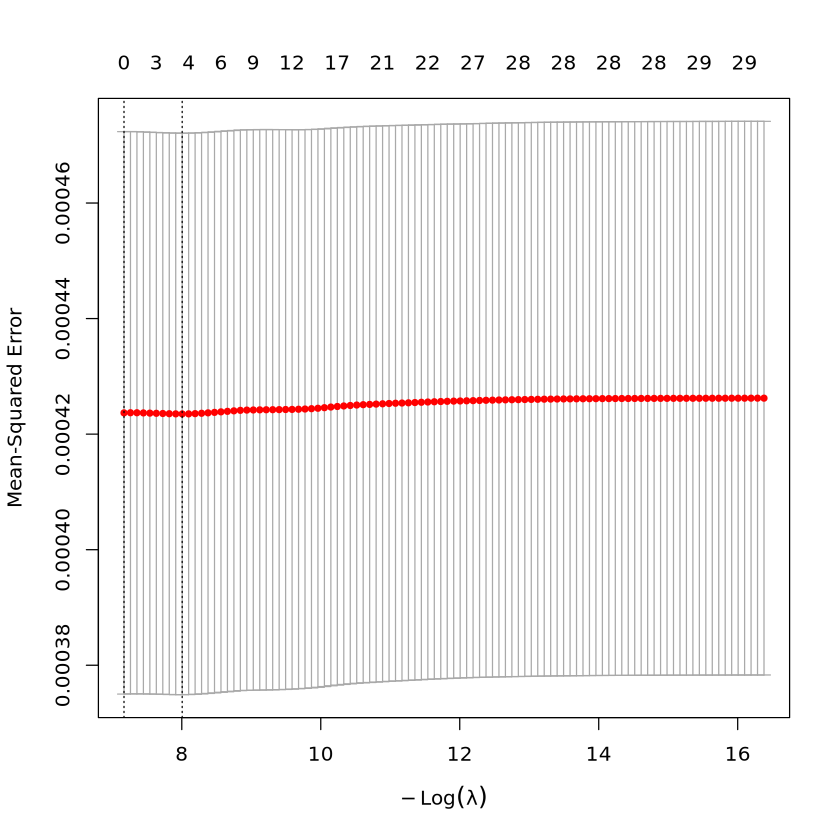

In [27]:
# Run Cross-Validation
set.seed(123) # For reproducibility
# alpha = 1 specifies LASSO (alpha = 0 would be Ridge)
cv_lasso = cv.glmnet(x_train, y_train, alpha = 1)

# Plot the error vs. Lambda
plot(cv_lasso)

In [28]:
# Extract coefficients at the '1-standard-error' lambda
best_coefs = coef(cv_lasso, s = "lambda.1se")

# Convert to a readable format to see which variables are NOT zero
coef_df = data.frame(
  Variable = rownames(best_coefs),
  Coefficient = as.numeric(best_coefs)
) %>% 
  filter(Coefficient != 0 & Variable != "(Intercept)") %>%
  arrange(desc(abs(Coefficient)))

print("Variables selected by LASSO:")
print(coef_df)

[1] "Variables selected by LASSO:"
[1] Variable    Coefficient
<0 rows> (or 0-length row.names)
